# Movie Recommendation System

In this first part of the project I'll be using the Scikit Surprise library to perform Content-based filtering, Item-based filtering and a hybrid of the two to recommend movies to users.

Initially, I meant to use the 1M MovieLens dataset in its entirety, meaning both the movies and ratings datasets. After performing some tests on the dataset mentioned, I found some issues and decided to change it. Mainly, the movies only had the genre information and the title, implying that any additional information had to scraped. Most importantly, the 1M ratings file contains around 1 million ratings, which is too big for my personal computer to handle.

After changing the dataset the first time I decided to use the Imdb dataset, which contains a lot more information for each movie in it (around 46k x 25 columns). Performing item-item similarities on so many datapoints was too demanding computationally-wise, so I'll be using a smaller version of this dataset, the Tmdb one. For the ratings, I'll be using the ratings_small, which contains around 100k ratings from different users.

The first approach is one I used for a personal project back in December, the second one is adapted from a tutorial found on Towards Data Science. 

In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 27.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3195809 sha256=cd6314f4d26d2061fb1e11cce3f60226027dadd7f3e496169f1d1958a01d844d
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


In [ ]:
# importing all the necessary libraries

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from ast import literal_eval
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [ ]:
# loading the two main datasets, movies and credits (additional info)

movies = pd.read_csv('/content/drive/MyDrive/thesis/tmdb_5000_movies.csv')
credits = pd.read_csv('/content/drive/MyDrive/thesis/tmdb_5000_credits.csv')

In [ ]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [ ]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


Columns in the movies dataset:

- Budget: movies' budget;
- Genres: movies' genres;
- Homepage: movies' homepages;
- id: Tmdb id;
- Keywords: movies' plotline keywords;
- Original language;
- Original title;
- Overview: movies' plots;
- Popularity: based on the Imdb dataset;
- Production companies;
- Production countries;
- Release date;
- Revenue;
- Runtime;
- Spoken languages;
- Status;
- Tagline;
- Title;
- Vote average (on Imdb);
- Vote count (# votes for each movie). 

Columns in the credits dataset:

- id;
- Cast;
- Crew.

The credits dataset contains the cast and crew for each movie, in addition to the id, used to perform the join operation in the following step.
Given that the two keys have different names, I'll rename the columns of the credits database first. 

In [ ]:
credits.columns = ['id', 'title', 'cast', 'crew']
credits.drop('title', axis = 1, inplace = True) # it would duplicate titles
movies = movies.merge(credits, on = 'id')

In [ ]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


Let's take a look at some general information about the movies DataFrame. 

In [ ]:
movies.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [ ]:
movies.dtypes

budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title                    object
vote_average            float64
vote_count                int64
cast                     object
crew                     object
dtype: object

In [ ]:
movies.isna().sum()     # homepage and tagline will not be used anyway

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
cast                       0
crew                       0
dtype: int64

**Demographic filtering**

First, a metric is needed to rate a movie; then, computing the score for every movie in the dataset and sort the scores and recommend the best rated movies to users. 

Imdb has its own metric, which I'm going to use, called weighted rating.

$WR = (\frac{v}{v+m} * R) + (\frac{m}{v+m} * C)$

where:

- v: # votes for the movie (vote_count in the dataset);
- m: minimum votes required to be listed in the chart;
- R: average rating of the movie (vote_average in the dataset);
- C: mean vote across the whole chart. 

We need to compute m and C. 

In [ ]:
C = movies['vote_average'].mean()
C

6.092171559442016

The average vote for all movies is 6.09 on a scale from 1 to 10.

To compute m, the 90th percentiles will be used as cutoff. This basically means that a movie needs to have more votes than at least 90% of all movies to be considered a candidate.

In [ ]:
m = movies['vote_count'].quantile(0.9)
m 

1838.4000000000015

In [ ]:
# applyting the mask to the DataFrame

filtered_movies = movies.loc[movies['vote_count'] >= m]
filtered_movies.shape

(481, 22)

So we went from 5000 movies to 481. Now we compute WR for each movie in filtered dataset.

In [ ]:
def compute_WR(df, m = m, C = C):
  v = df['vote_count']
  R = df['vote_average']

  return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
filtered_movies['score'] = filtered_movies.apply(compute_WR, axis = 1)

In [ ]:
# sorting the movies in the DF based on the score

filtered_movies.sort_values('score', ascending = False, inplace = True)

# picking the first 15 (only selected features)

filtered_movies[['original_title', 'vote_count', 'vote_average', 'score']].head(15)

,original_title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


Glad to see that the Lord of the Rings trilogy is rated so high. Not happy about the fact the Nolan's movies are rated higher though. De gustibus, I guess. 

The movies below represent the "trending" ones, basically the ones that users enjoy the most and have watched the most. This is what a new user might find when logging onto a streaming platform for the first time: to overcome the cold start problem, they display a bunch of movies that are popular and user might enjoy. -- Another solution to overcome the cold start can be given by the contextual multi-arms bandit algorithm (coming at a later date). 

Displaying the most popular movies below.

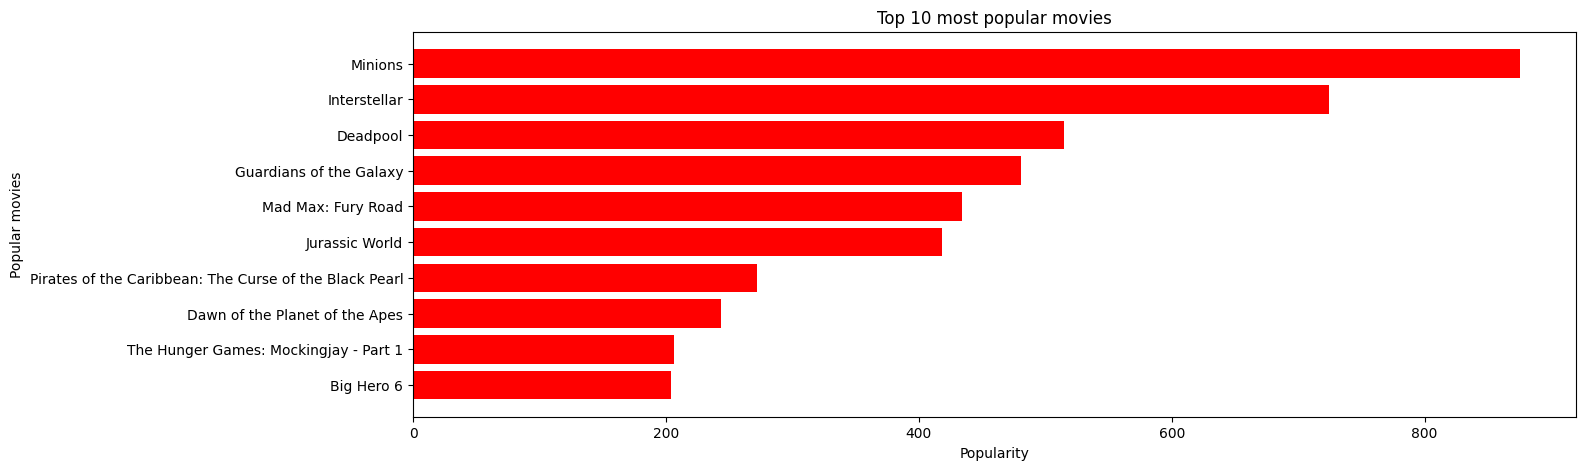

In [ ]:
popular_movies = movies.sort_values('popularity', ascending = False)
plt.figure(figsize = (15, 5))

plt.barh(popular_movies['original_title'].head(10), popular_movies['popularity'].head(10),
         align = 'center', color = 'red')
plt.gca().invert_yaxis()
plt.xlabel('Popularity')
plt.ylabel('Popular movies')
plt.title('Top 10 most popular movies')
plt.show()

**Content-based filtering** 

Similar movies to each other are more likely to be recommended to users.

The "overview" column of the movies dataset contains the soryline. 
I'll compute pair-wise similarity scores for all movies based on the plot of each movie and recommend the ones with similar stories. 

In [ ]:
tfidf = TfidfVectorizer(stop_words = 'english')

movies['overview'].fillna('', inplace = True)

tfidf_matrix = tfidf.fit_transform(movies['overview'])

tfidf_matrix.shape

(4803, 20978)

Applying cosine similarity, defined as:

$similarity = cos(θ) = \frac{\sum_{i=1}^{n} A_iB_i}{\sqrt{\sum_{i=1}^{n} A_i^2}{\sqrt{\sum_{i=1}^{n} B_i^2}}}$

In [ ]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

indices = pd.Series(movies.index, index = movies['original_title']).drop_duplicates()

In [ ]:
def get_recommendations(movie_title, cosine_sim = cosine_sim):
    idx = indices[movie_title] # get the index of the movie that has a given title
    similarity_scores = list(enumerate(cosine_sim[idx])) # get all pairwise similarity scores for all movies 
    similarity_scores = sorted(similarity_scores, key = lambda x : x[1], reverse = True) # sort movies based on similarity
    similarity_scores = similarity_scores[1:11] # get the scores of the first 10 most similar movies
    movies_indices = [i[0] for i in similarity_scores] # get movie indices
    
    return movies['original_title'].iloc[movies_indices] # return idx and title

In [ ]:
get_recommendations('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: original_title, dtype: object

In [ ]:
get_recommendations('Avatar')

3604                       Apollo 18
2130                    The American
634                       The Matrix
1341                Obitaemyy Ostrov
529                 Tears of the Sun
1610                           Hanna
311     The Adventures of Pluto Nash
847                         Semi-Pro
775                        Supernova
2628             Blood and Chocolate
Name: original_title, dtype: object

In [ ]:
get_recommendations('Toy Story')

42                 Toy Story 3
343                Toy Story 2
1779    The 40 Year Old Virgin
2869    For Your Consideration
891            Man on the Moon
3873             Class of 1984
3379              Factory Girl
3065                Heartbeeps
3383                 Losin' It
2569               Match Point
Name: original_title, dtype: object

In [ ]:
get_recommendations('The Avengers')

7               Avengers: Age of Ultron
3144                            Plastic
1715                            Timecop
4124                 This Thing of Ours
3311              Thank You for Smoking
3033                      The Corruptor
588     Wall Street: Money Never Sleeps
2136         Team America: World Police
1468                       The Fountain
1286                        Snowpiercer
Name: original_title, dtype: object

The recommendation function above is solely based on plots. 

Below, I'll focus on different criteria, namely the top 3 actors, director, related genres and the movie plot keywords. 

Give that the cast, crew and keyword feature are in json format, we first need to extract the data we need. 

In [ ]:
features = ['cast', 'crew', 'keywords', 'genres']

for f in features:
  movies[f] = movies[f].apply(literal_eval)

In [ ]:
def get_director(crew):
  for i in crew:
    if i['job'] == 'Director':
      return i['name']
  return np.nan

In [ ]:
def get_top_three(crew):
  if isinstance(crew, list):
    names = [i['name'] for i in crew]
    # if more than 3 elements exist, return the first 3, else return all list
    if len(names) > 3:
      names = names[:3]
    return names
  return []

In [ ]:
movies['director'] = movies['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']

for f in features:
  movies[f] = movies[f].apply(get_top_three)

In [ ]:
movies[['original_title', 'cast', 'director', 'keywords', 'genres']].head(3)

,original_title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [ ]:
# cleaning the new strings -> converting to lowercase and strip spaces

def clean_strings(strings):
  if isinstance(strings, list):
    return [str.lower(i.replace(' ', '')) for i in strings]
  else:
    if isinstance(strings, str): # director case
      return str.lower(strings.replace(' ', ''))
    else:
      return ''

In [ ]:
features = ['cast', 'keywords', 'director', 'genres']

for f in features:
  movies[f] = movies[f].apply(clean_strings)

In [ ]:
# now I'll mix all the metadata in order to feed it to the Count Vectorizer

def create_mix(strings):
  return ' '.join(strings['keywords']) + ' ' + ' '.join(strings['cast']) + ' ' + \
         strings['director'] + ' ' + ' '.join(strings['genres'])

movies['mix'] = movies.apply(create_mix, axis = 1)

In [ ]:
count = CountVectorizer(stop_words = 'english')
count_matrix = count.fit_transform(movies['mix'])

In [ ]:
count_matrix.shape

(4803, 11520)

In [ ]:
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [ ]:
df = movies.copy()
df.reset_index(inplace = True)
indices = pd.Series(df.index, index = df['original_title'])

In [ ]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: original_title, dtype: object

In [ ]:
get_recommendations('The Avengers', cosine_sim2)

7                  Avengers: Age of Ultron
26              Captain America: Civil War
79                              Iron Man 2
169     Captain America: The First Avenger
174                    The Incredible Hulk
85     Captain America: The Winter Soldier
31                              Iron Man 3
33                   X-Men: The Last Stand
68                                Iron Man
94                 Guardians of the Galaxy
Name: original_title, dtype: object

In [ ]:
get_recommendations('Toy Story', cosine_sim2)

42                                            Toy Story 3
343                                           Toy Story 2
40                                                 Cars 2
533                                         Monster House
1983                                     Meet the Deedles
3403    Alpha and Omega: The Legend of the Saw Tooth Cave
927                             Christmas with the Kranks
120                           Madagascar: Escape 2 Africa
725                                        The Shaggy Dog
1451                                                 Zoom
Name: original_title, dtype: object

In [ ]:
get_recommendations('Avatar', cosine_sim2)

206                         Clash of the Titans
71        The Mummy: Tomb of the Dragon Emperor
786                                西游记之孙悟空三打白骨精
103                   The Sorcerer's Apprentice
131                                     G-Force
215                4: Rise of the Silver Surfer
466                            The Time Machine
715                           The Scorpion King
1      Pirates of the Caribbean: At World's End
5                                  Spider-Man 3
Name: original_title, dtype: object

As we can see, by taking into account the cast, director and genres we get a more "real" recommendation. By taking a closer look at the movies similar to "The Avengers" we can denote that other than the sequel, the remaining titles are all Marvel movies, which is better than what we got by considering the plot movie alone. 

**Collaborative filtering**
- User based filtering: products that similar users liked are recommended to others. Again, we can use cosine similarity or Pearson correlation. 
- Item based collaborative filtering: instead of measuring similarity between users, the item-based CF recommends items based on their similarity with the items that the target user rated. This methodology has two main issues: scalability $[O(mn)]$ with m the number of users and n the items; and sparsity. 

**Single Value Decomposition**

To handle the scalability and sparsity issue, one can leverage a latent factor model. 
Latent Factor models are a state of the art methodology for model-based collaborative filtering. The basic assumption is that there exist an unknown low-dimensional representation of users and items where user-item affinity can be modeled accurately. For example, the rating that a user gives to a movie might be assumed to depend on few implicit factors such as the user’s taste across various movie genres. Matrix factorization techniques are a class of widely successful Latent Factor models that attempt to find weighted low-rank approximations to the user-item matrix, where weights are used to hold out missing entries. There is a large family of matrix factorization models based on choice of loss function to measure approximation quality, regularization terms to avoid overfitting, and other domain-dependent formulations.

By doing this, the recommendation problem turns into an optimization one. One common metric in this case is the RMSE. (the lower the RMSE, the better the performance). 

SVD decreases the dimension of the utility matrix by extracting the latent factors. Essentially, each user and item is mapped into a latent space with dimension r. 

In [ ]:
# handling the ratings will be done via the surprise library by scikit

reader = Reader()
ratings = pd.read_csv('/content/drive/MyDrive/thesis/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
# Ratings in this case are from 1 to 5, unlike the Imdb one where they go from 1 to 10. 

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader) # we don't need the timestamp
svd = SVD()
cross_validate(svd, data, measures = ['RMSE', 'MAE'], cv = 5)

{'test_rmse': array([0.89363616, 0.90355724, 0.89269687, 0.89361673, 0.89540618]),
 'test_mae': array([0.68802821, 0.69550583, 0.68574102, 0.68833227, 0.69004732]),
 'fit_time': (2.0007646083831787,
  1.0376195907592773,
  1.0882518291473389,
  1.0749223232269287,
  1.0821576118469238),
 'test_time': (0.27512669563293457,
  0.10232329368591309,
  0.26497364044189453,
  0.11182665824890137,
  0.17216110229492188)}

In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
# let's take a closer look at the ratings of userId = 1

ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [ ]:
svd.predict(1, 302, 3) # userid = 1, movieid = 302, true_rating

Prediction(uid=1, iid=302, r_ui=3, est=2.631646298125254, details={'was_impossible': False})

In [ ]:
# The model build above is simple, but it works. 
# Let's try to improve it but keeping the format similar.

In [ ]:
movies = pd.read_csv('/content/drive/MyDrive/thesis/tmdb_5000_movies.csv')
credits = pd.read_csv('/content/drive/MyDrive/thesis/tmdb_5000_credits.csv')

In [ ]:
credits.columns = ['id', 'title', 'cast', 'crew']
credits.drop('title', axis = 1, inplace = True) # it would duplicate titles
movies = movies.merge(credits, on = 'id')

In [ ]:
# cleaning the genres column 

movies['genres'] = movies['genres'].fillna('[]').apply(literal_eval).apply(lambda x : [i['name'] for i in x] if isinstance(x, list) else [])

In [ ]:
# same approach as before, we compute C and m 

vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')

C = vote_averages.mean()
C

5.6529252550489275

In [ ]:
m = vote_counts.quantile(0.9)
m

1838.4000000000015

In [ ]:
# let's extract the year a movie came out from the release date column

movies['year'] = pd.to_datetime(movies['release_date'], errors = 'coerce').apply(lambda x : str(x).split('-')[0] if x != np.nan else np.nan)

In [ ]:
qualified_movies = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified_movies['vote_count'] = qualified_movies['vote_count'].astype('int')
qualified_movies['vote_average'] = qualified_movies['vote_average'].astype('int')
qualified_movies.shape

(481, 6)

In [ ]:
# as before, we have 481 movies
# let's apply the weighted average again

qualified_movies['wr'] = qualified_movies.apply(compute_WR, axis = 1)

In [ ]:
# only picking the first 250
qualified_movies = qualified_movies.sort_values('wr', ascending = False).head(250)
# displaying the first 15 
qualified_movies.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
96,Inception,2010,13752,8,167.583710,"[Action, Thriller, Science Fiction, Mystery, A...",7.775031
65,The Dark Knight,2008,12002,8,187.322927,"[Drama, Action, Crime, Thriller]",7.746586
95,Interstellar,2014,10867,8,724.247784,"[Adventure, Drama, Science Fiction]",7.723948
662,Fight Club,1999,9413,8,146.757391,[Drama],7.688274
262,The Lord of the Rings: The Fellowship of the Ring,2001,8705,8,138.049577,"[Adventure, Fantasy, Action]",7.667341
3232,Pulp Fiction,1994,8428,8,121.463076,"[Thriller, Crime]",7.658366
1881,The Shawshank Redemption,1994,8205,8,136.747729,"[Drama, Crime]",7.650780
329,The Lord of the Rings: The Return of the King,2003,8064,8,123.630332,"[Adventure, Fantasy, Action]",7.645808
809,Forrest Gump,1994,7927,8,138.133331,"[Comedy, Drama, Romance]",7.640839
330,The Lord of the Rings: The Two Towers,2002,7487,8,106.914973,"[Adventure, Fantasy, Action]",7.623893


We can denote that some movies, like the ones directed by Nolan (overrated?) are at the top of the chart. The chart is also biased towards some genres and directors. 

Let's construct a function that build charts for specific genres. The percentile condition for this will be .85 instead of .90. 

In [ ]:
s = movies.apply(lambda x : pd.Series(x['genres']), axis = 1).stack().reset_index(level = 1, drop = True)
s.name = 'genre'
genres_data = movies.drop('genres', axis = 1).join(s)

In [ ]:
s

0                Action
0             Adventure
0               Fantasy
0       Science Fiction
1             Adventure
             ...       
4800             Comedy
4800              Drama
4800            Romance
4800           TV Movie
4802        Documentary
Name: genre, Length: 12160, dtype: object

In [ ]:
genres_data 
# a line for each genre
# for example avatar has 4 lines: action, adventure, fantasy and science fiction

,budget,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,...,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,year,genre
0,237000000,http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",2009,Action
0,237000000,http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",2009,Adventure
0,237000000,http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",2009,Fantasy
0,237000000,http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",2009,Science Fiction
1,300000000,http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",2007,Adventure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4800,0,http://www.hallmarkchannel.com/signedsealeddel...,231617,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""id"": 3958}...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,"Signed, Sealed, Delivered",7.0,6,"[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de...",2013,Drama
4800,0,http://www.hallmarkchannel.com/signedsealeddel...,231617,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""id"": 3958}...","[{""iso_3166_1"": ""US"", ""name"": 

In [ ]:
def build_chart(genre, percentile = 0.85):
  df = genres_data[genres_data['genre'] == genre]
  vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
  vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
  C = vote_averages.mean()
  m = vote_counts.quantile(percentile)

  qualified_movies = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
  qualified_movies['vote_count'] = qualified_movies['vote_count'].astype('int')
  qualified_movies['vote_average'] = qualified_movies['vote_average'].astype('int')

  qualified_movies['wr'] = qualified_movies.apply(lambda x : (x['vote_count'] / (x['vote_count'] + m) * x['vote_average']) + (m / (m + x['vote_count']) * C), axis = 1)
  qualified_movies = qualified_movies.sort_values('wr', ascending = False).head(250)

  return qualified_movies

In [ ]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
809,Forrest Gump,1994,7927,8,138.133331,7.766263
25,Titanic,1997,7562,7,100.025899,6.864585
81,Maleficent,2014,4496,7,110.620647,6.787914
1997,Her,2013,4097,7,53.682367,6.771045
49,The Great Gatsby,2013,3769,7,61.196071,6.755026
2838,The Fault in Our Stars,2014,3759,7,74.358971,6.754503
2152,Eternal Sunshine of the Spotless Mind,2004,3652,7,56.481487,6.748756
2108,Edward Scissorhands,1990,3601,7,47.513630,6.745921
1695,Aladdin,1992,3416,7,92.982009,6.735079
2547,The Theory of Everything,2014,3311,7,61.182331,6.728503


**Content-based recommender again**

In [ ]:
links = pd.read_csv('/content/drive/MyDrive/thesis/links.csv')
links = links[links['tmdbId'].notnull()]['tmdbId'].astype('int')

In [ ]:
links.head()

0      862
1     8844
2    15602
3    31357
4    11862
Name: tmdbId, dtype: int64

In [ ]:
movies['id'] = movies['id'].astype('int')

In [ ]:
df = movies[movies['id'].isin(links)]
df.shape

(4595, 23)

In [ ]:
df.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'cast', 'crew', 'year'],
      dtype='object')

In [ ]:
df['tagline'] = df['tagline'].fillna('')
df['description'] = df['overview'] + df['tagline']
df['description'] = df['description'].fillna('')

In [ ]:
tf = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 2), min_df = 0, stop_words = 'english')
tfidf_matrix = tf.fit_transform(df['description'])

In [ ]:
tfidf_matrix.shape

(4595, 143004)

In [ ]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
df = df.reset_index()
titles = df['title']
indices = pd.Series(df.index, index = df['title'])

In [ ]:
def get_recommendations(title):
  idx = indices[title] # index based on title
  sim_scores = list(enumerate(cosine_sim[idx])) # compute similarity scores for movie
  sim_scores = sorted(sim_scores, key = lambda x : x[1], reverse = True) # sort them
  sim_scores = sim_scores[1:31] # pick first 30 
  movie_indices = [i[0] for i in sim_scores] # create a list of indices

  return titles.iloc[movie_indices] # return titles based on indices

In [ ]:
get_recommendations('The Godfather').head(10)

2711     The Godfather: Part II
1865                 Blood Ties
3583                       Made
3674                 Easy Money
3137              Loose Cannons
1468          Playing for Keeps
2028              Summer of Sam
864     The Godfather: Part III
978               Run All Night
3242                    8 Women
Name: title, dtype: object

In [ ]:
get_recommendations('The Dark Knight').head(10)

3                         The Dark Knight Rises
298                              Batman Forever
427                              Batman Returns
3797    Batman: The Dark Knight Returns, Part 2
1353                                     Batman
2490                                  Slow Burn
1175                                        JFK
119                               Batman Begins
876                         Law Abiding Citizen
204          Sherlock Holmes: A Game of Shadows
Name: title, dtype: object

In [ ]:
df.columns

Index(['index', 'budget', 'genres', 'homepage', 'id', 'keywords',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'cast', 'crew', 'year', 'description'],
      dtype='object')

In [ ]:
df['cast'] = df['cast'].apply(literal_eval) # cant use inplace with literal_eval
df['crew'] = df['crew'].apply(literal_eval)
df['keywords'] = df['keywords'].apply(literal_eval)
df['cast_size'] = df['cast'].apply(lambda x : len(x))
df['crew_size'] = df['crew'].apply(lambda x : len(x))

In [ ]:
# same cleaning process as before 

df['director'] = df['crew'].apply(get_director)
df['cast'] = df['cast'].apply(lambda x : [i['name'] for i in x] if isinstance(x, list) else [])
df['cast'] = df['cast'].apply(lambda x : x[:3] if len(x) >= 3 else x)
df['keywords'] = df['keywords'].apply(lambda x : [i['name'] for i in x] if isinstance(x, list) else [])
df['cast'] = df['cast'].apply(lambda x : [str.lower(i.replace(' ', '')) for i in x])
df['director'] = df['director'].astype('str').apply(lambda x : str.lower(x.replace(' ', '')))
df['director'] = df['director'].apply(lambda x : [x, x, x])

In [ ]:
df.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,title,vote_average,vote_count,cast,crew,year,description,cast_size,crew_size,director
0,0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,Avatar,7.2,11800,"[samworthington, zoesaldana, sigourneyweaver]","[{'credit_id': '52fe48009251416c750aca23', 'de...",2009,"In the 22nd century, a paraplegic Marine is di...",83,153,"[jamescameron, jamescameron, jamescameron]"
1,1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,Pirates of the Caribbean: At World's End,6.9,4500,"[johnnydepp, orlandobloom, keiraknightley]","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",2007,"Captain Barbossa, long believed to be dead, ha...",34,32,"[goreverbinski, goreverbinski, goreverbinski]"
2,2,245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, based on novel, secret agent, sequel, mi...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,Spectre,6.3,4466,"[danielcraig, christophwaltz, léaseydoux]","[{'credit_id': '54805967c3a36829b5002c41', 'de...",2015,A cryptic message from Bond’s past sends him o...,83,155,"[sammendes, sammendes, sammendes]"
3,3,250000000,"[Action, Crime, Drama, Thriller]",http://www.thedarkknightrises.com/,49026,"[dc comics, crime fighter, terrorist, secret i...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,The Dark Knight Rises,7.6,9106,"[christianbale, michaelcaine, garyoldman]","[{'credit_id': '52fe4781c3a36847f81398c3', 'de...",2012,Following the death of District Attorney Harve...,158,217,"[christophernolan, christophernolan, christoph..."
4,4,260000000,"[Action, Adventure, Science Fiction]",http://movies.disney.com/john-carter,49529,"[based on novel, mars, medallion, space travel...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,John Carter,6.1,2124,"[taylorkitsch, lynncollins, samanthamorton]","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de...",2012,"John Carter is a war-weary, former military ca...",27,132,"[andrewstanton, andrewstanton, andrewstanton]"


In [ ]:
# keywords pre-processing

s = df.apply(lambda x : pd.Series(x['keywords']), axis = 1).stack().reset_index(level = 1, drop = True)
s.name = 'keywords'

In [ ]:
s = s.value_counts()
s[:5]

woman director          309
independent film        309
duringcreditsstinger    307
based on novel          197
murder                  184
Name: keywords, dtype: int64

In [ ]:
s = s[s > 1]

In [ ]:
stemmer = SnowballStemmer('english')

In [ ]:
def filter_keywords(keywords):
  words = []
  for k in keywords:
    if k in s:
      words.append(k)
  
  return words

In [ ]:
df['keywords'] = df['keywords'].apply(filter_keywords)
df['keywords'] = df['keywords'].apply(lambda x : [stemmer.stem(i) for i in x])
df['keywords'] = df['keywords'].apply(lambda x : [str.lower(i.replace(' ', '')) for i in x])

In [ ]:
df['mix'] = df['keywords'] + df['cast'] + df['director'] + df['genres']
df['mix'] = df['mix'].apply(lambda x : ' '.join(x))

In [ ]:
count = CountVectorizer(analyzer = 'word', ngram_range = (1, 2), min_df = 0, stop_words = 'english')
count_matrix = count.fit_transform(df['mix'])

In [ ]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
df.reset_index(inplace = True)
titles = df['title']
indices = pd.Series(df.index, index = df['title'])

In [ ]:
get_recommendations('The Dark Knight').head(10)

3                    The Dark Knight Rises
119                          Batman Begins
1190                          The Prestige
96                               Inception
1029                              Insomnia
3533                               Memento
95                            Interstellar
427                         Batman Returns
209                         Batman & Robin
9       Batman v Superman: Dawn of Justice
Name: title, dtype: object

As before, mixed with titles from the same series we get titles from the same director and similar genres. 

Let's improve the recommendation system to that movies with a bad critical response are removed from the list of movies that get recommended to users. 

In [ ]:
def improved_recommendations(title):
  idx = indices[title]
  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores, key = lambda x : x[1], reverse = True)
  sim_scores = sim_scores[1:31]
  movie_indices = [i[0] for i in sim_scores]

  movies = df.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
  vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
  vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
  C = vote_averages.mean()
  m = vote_counts.quantile(0.6)
  qualified_movies = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
  qualified_movies['vote_count'] = qualified_movies['vote_count'].astype('int')
  qualified_movies['vote_average'] = qualified_movies['vote_average'].astype('int')
  qualified_movies['wr'] = qualified_movies.apply(compute_WR, axis = 1)
  qualified_movies = qualified_movies.sort_values('wr', ascending = False).head(10)

  return qualified_movies

In [ ]:
improved_recommendations('The Dark Knight')

,title,vote_count,vote_average,year,wr
96,Inception,13752,8,2010,7.775031
95,Interstellar,10867,8,2014,7.723948
1190,The Prestige,4391,8,2006,7.436968
3533,Memento,4028,8,2000,7.402129
3,The Dark Knight Rises,9106,7,2012,6.847506
119,Batman Begins,7359,7,2005,6.818541
1712,Kick-Ass,4645,7,2010,6.742581
1353,Batman,2096,7,1989,6.575805
427,Batman Returns,1673,6,1992,6.048257
1732,Kick-Ass 2,2224,6,2013,6.041711


Compared to before, we no longer get recommendations for movies with a really bad rating, like "Batman and Robin".

In [ ]:
improved_recommendations('The Avengers')

,title,vote_count,vote_average,year,wr
785,Deadpool,10995,7,2016,6.869952
94,Guardians of the Galaxy,9742,7,2014,6.855881
68,Iron Man,8776,7,2008,6.842765
26,Captain America: Civil War,7241,7,2016,6.816183
7,Avengers: Age of Ultron,6767,7,2015,6.806058
46,X-Men: Days of Future Past,6032,7,2014,6.787946
182,Ant-Man,5880,7,2015,6.783770
14,Man of Steel,6359,6,2013,6.020671
129,Thor,6525,6,2011,6.020261
79,Iron Man 2,6849,6,2010,6.019505


In [ ]:
improved_recommendations('Toy Story')

,title,vote_count,vote_average,year,wr
66,Up,6870,7,2009,6.808351
230,"Monsters, Inc.",5996,7,2001,6.786971
42,Toy Story 3,4597,7,2010,6.740661
342,Toy Story 2,3806,7,1999,6.704317
742,The Lego Movie,3070,7,2014,6.659980
1251,Fantastic Mr. Fox,1176,7,2009,6.446340
702,Antz,1272,6,1998,6.054478
440,Robots,1333,6,2005,6.053430
346,Cloudy with a Chance of Meatballs,1747,6,2009,6.047261
178,Rango,2051,6,2011,6.043567


**CF Again**

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

svd = SVD()
cross_validate(svd, data = data, measures = ['RMSE', 'MAE'], cv = 5)

{'test_rmse': array([0.90582826, 0.89170905, 0.89645174, 0.89684299, 0.88803056]),
 'test_mae': array([0.69722118, 0.68691548, 0.68988565, 0.68775643, 0.68521259]),
 'fit_time': (2.830587387084961,
  1.2757635116577148,
  1.0407028198242188,
  1.0180244445800781,
  1.0348186492919922),
 'test_time': (0.1882014274597168,
  0.321622371673584,
  0.09711122512817383,
  0.11095237731933594,
  0.10632896423339844)}

In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [ ]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.6612744718410783, details={'was_impossible': False})

**Hybrid recommender**

In [ ]:
def convert_int(id):
  try:
    return int(id)
  except:
    return np.nan

In [ ]:
id_map = pd.read_csv('/content/drive/MyDrive/thesis/links.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(df[['title', 'id']], on = 'id').set_index('title')

In [ ]:
indices_map = id_map.set_index('id')

In [ ]:
def hybrid_recommendation(userId, title):
  idx = indices[title]
  tmdbId = id_map.loc[title]['id']
  movie_id = id_map.loc[title]['movieId']

  sim_scores = list(enumerate(cosine_sim[int(idx)]))
  sim_scores = sorted(sim_scores, key = lambda x : x[1], reverse = True)
  sim_scores = sim_scores[1:31]
  movie_indices = [i[0] for i in sim_scores]

  movies = df.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
  movies['est'] = movies['id'].apply(lambda x : svd.predict(userId, indices_map.loc[x]['movieId']).est)
  movies = movies.sort_values('est', ascending = False)

  return movies.head(10)

In [ ]:
hybrid_recommendation(1, 'Avatar')

,title,vote_count,vote_average,year,id,est
2386,Aliens,3220,7.7,1986,679,3.236528
3402,The Terminator,4128,7.3,1984,218,3.197535
321,The Fifth Element,3885,7.3,1997,18,3.131284
278,Terminator 2: Judgment Day,4185,7.7,1991,280,3.101968
46,X-Men: Days of Future Past,6032,7.5,2014,127585,2.935285
47,Star Trek Into Darkness,4418,7.4,2013,54138,2.857877
585,The Abyss,808,7.1,1989,2756,2.836618
72,Suicide Squad,7458,5.9,2016,297761,2.825709
14,Man of Steel,6359,6.5,2013,49521,2.798423
2153,The Covenant,288,5.2,2006,9954,2.793654


In [ ]:
hybrid_recommendation(500, 'Avatar')

,title,vote_count,vote_average,year,id,est
278,Terminator 2: Judgment Day,4185,7.7,1991,280,3.562172
3402,The Terminator,4128,7.3,1984,218,3.426990
281,True Lies,1116,6.8,1994,36955,3.245815
47,Star Trek Into Darkness,4418,7.4,2013,54138,3.130275
2311,Predator,2093,7.3,1987,106,3.101178
46,X-Men: Days of Future Past,6032,7.5,2014,127585,3.072766
25,Titanic,7562,7.5,1997,597,3.063410
237,Teenage Mutant Ninja Turtles,2636,5.8,2014,98566,3.049343
321,The Fifth Element,3885,7.3,1997,18,2.991217
856,Thunderbirds,91,4.2,2004,14623,2.988147


# Approach 2 

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [43]:
movies_df = pd.read_csv('/content/drive/MyDrive/thesis/tmdb_5000_movies.csv')
credits_df = pd.read_csv('/content/drive/MyDrive/thesis/tmdb_5000_credits.csv')

In [44]:
credits_df.columns = ['id', 'title', 'cast', 'crew']
credits_df.drop('title', axis = 1, inplace = True) # it would duplicate titles
movies_df = movies_df.merge(credits_df, on = 'id')

In [45]:
links = pd.read_csv('/content/drive/MyDrive/thesis/links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [46]:
movies_df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


The movie_df id is the tmdbId -> This needs to be mapped to the Imdb id. 

This is because the Posters dataset has the Imdb id as the key and posters are needed for the second part of the project anyways. 

In [47]:
movies_df.rename(columns = {'id' : 'tmdbId'}, inplace = True)
movies_df.head()

,budget,genres,homepage,tmdbId,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [48]:
movies_df = movies_df.merge(links, on = 'tmdbId')
movies_df.head()

,budget,genres,homepage,tmdbId,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,movieId,imdbId
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",72998,499549
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",53125,449088
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",136020,2379713
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",91529,1345836
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",93363,401729


In [9]:
posters_df = pd.read_csv('/content/drive/MyDrive/thesis/MovieGenre.csv', engine = 'python',
                         encoding = 'ISO-8859-1')
posters_df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


In [49]:
movies_df = movies_df.merge(posters_df, on = 'imdbId')
movies_df.head()

,budget,genres,homepage,tmdbId,keywords,original_language,original_title,overview,popularity,production_companies,...,vote_count,cast,crew,movieId,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",72998,499549,http://www.imdb.com/title/tt499549,Avatar (2009),7.8,Action|Adventure|Fantasy,https://images-na.ssl-images-amazon.com/images...
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",53125,449088,http://www.imdb.com/title/tt449088,Pirates of the Caribbean: At World's End (2007),7.1,Action|Adventure|Fantasy,https://images-na.ssl-images-amazon.com/images...
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",136020,2379713,http://www.imdb.com/title/tt2379713,Spectre (2015),6.8,Action|Adventure|Thriller,https://images-na.ssl-images-amazon.com/images...
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",91529,1345836,http://www.imdb.com/title/tt1345836,The Dark Knight Rises (2012),8.5,Action|Thriller,https://images-na.ssl-images-amazon.com/images...
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",93363,401729,http://www.imdb.com/title/tt401729,John Carter (2012),6.6,Action|Adventure|Sci-Fi,https://images-na.ssl-images-amazon.com/images...


In [11]:
movies_df.isna().sum()

budget                     0
genres                     0
homepage                2972
tmdbId                     0
keywords                   0
original_language          0
original_title             0
overview                   1
popularity                 0
production_companies       0
production_countries       0
release_date               0
revenue                    0
runtime                    0
spoken_languages           0
status                     0
tagline                  709
title                      0
vote_average               0
vote_count                 0
cast                       0
crew                       0
movieId                    0
imdbId                     0
Imdb Link                  0
Title                      0
IMDB Score                 0
Genre                      0
Poster                     0
dtype: int64

In [ ]:
movies_df.to_csv('/content/drive/MyDrive/thesis/tmdb_with_posters.csv')

In [12]:
movies_df.shape

(4693, 29)

To gather posters, I used the following dataset found on Kaggle. 

Link: https://www.kaggle.com/datasets/neha1703/movie-genre-from-its-poster

By performing the inner join (merge operation on pandas), I went from 5000 movies to 4693 but all these movies have both a plot and a poster. 

In [ ]:
5000-4693 # 307 movies have been deleted 

307

In [13]:
movies_df['year'] = pd.to_datetime(movies_df['release_date'], errors = 'coerce').apply(lambda x : str(x).split('-')[0] if x != np.nan else np.nan)

In [14]:
movies_df['Genre'] = movies_df['Genre'].apply(lambda x : x.split('|'))

In [16]:
ratings = pd.read_csv('/content/drive/MyDrive/thesis/ratings_small.csv')

In [17]:
user_movie_content = pd.DataFrame(columns = [_ for _ in movies_df.tmdbId.unique()], index = [_ for _ in ratings.userId.unique()])

In [18]:
user_movie_content = user_movie_content.replace({np.nan : 0})

In [19]:
for i in range(ratings.shape[0]):
  user_movie_content.iloc[int(ratings.iloc[i]['userId']) -1][int(ratings.iloc[i]['movieId'])] = ratings.iloc[i]['rating']

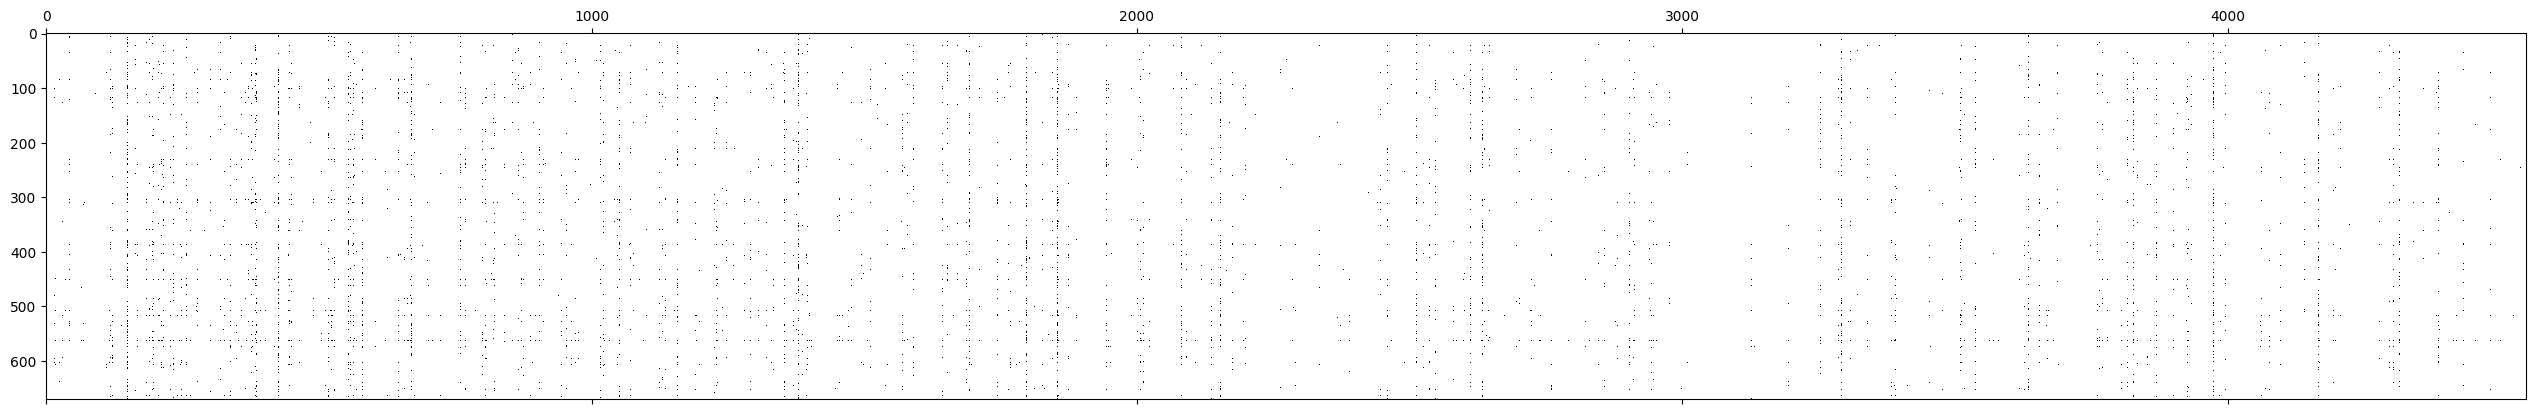

In [20]:
fig = plt.figure(figsize = (32, 32))
plt.spy(user_movie_content) # checking the sparsity of the matrix

In [21]:
from surprise import NormalPredictor, Dataset, Reader
from surprise.model_selection import cross_validate

reader = Reader(rating_scale = (1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [22]:
from surprise import SVD, SVDpp, KNNBasic, NMF, CoClustering, SlopeOne

algo1 = SVD()
algo2 = KNNBasic()
algo3 = NMF()
algo4 = CoClustering()
algo5 = SlopeOne()

In [23]:
algo1_dict = cross_validate(algo1, data, measures = ['RMSE', 'MAE'], cv = 5, verbose = False)
algo2_dict = cross_validate(algo2, data, measures = ['RMSE', 'MAE'], cv = 5, verbose = False)
algo3_dict = cross_validate(algo3, data, measures = ['RMSE', 'MAE'], cv = 5, verbose = False)
algo4_dict = cross_validate(algo4, data, measures = ['RMSE', 'MAE'], cv = 5, verbose = False)
algo5_dict = cross_validate(algo5, data, measures = ['RMSE', 'MAE'], cv = 5, verbose = False)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


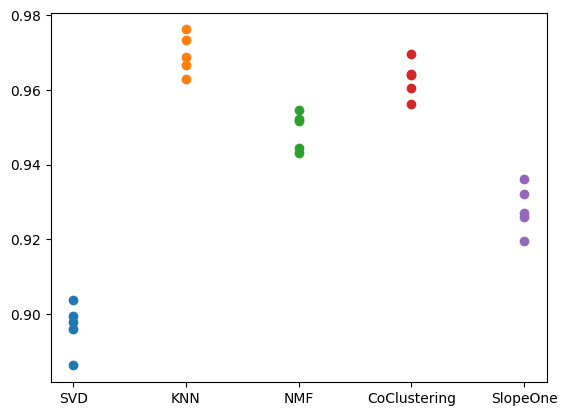

In [24]:
import matplotlib.pyplot as plt

algos = ['SVD', 'KNN', 'NMF', 'CoClustering', 'SlopeOne']
x_pos = np.arange(float(len(algos)))

Y = [algo1_dict['test_rmse'], algo2_dict['test_rmse'], algo3_dict['test_rmse'], algo4_dict['test_rmse'], algo5_dict['test_rmse']]
for y in range(len(Y)):
  plt.scatter([algos[y], algos[y], algos[y], algos[y], algos[y]], Y[y], marker = 'o')

In [25]:
from collections import defaultdict

In [26]:
def get_top_n(predictions, n = 10):
  # return top n recommendations for each user 
  # predictions = list of predictions object, returned by the test algorithm
  # n = # of recommendations to output

  top_n = defaultdict(list)
  for uid, iid, true_r, est, _ in predictions: # map predictions to each user
    top_n[uid].append((iid, est))

  for uid, user_ratings in top_n.items(): # sort predictions for each user 
    user_ratings.sort(key = lambda x : x[1], reverse = True)
    top_n[uid] = user_ratings[:n] # pick the n highest ones

  return top_n # dict with list of tuples (id, rating_estimation) of size n

In [27]:
trainset = data.build_full_trainset()
algo1.fit(trainset)

testset = trainset.build_anti_testset()
predictions = algo1.test(testset)

top_n = get_top_n(predictions, n = 10)

In [29]:
for uid, user_ratings in top_n.items():
  print(uid, [iid for (iid, _) in user_ratings])

1 [858, 318, 1252, 1221, 6016, 7502, 1193, 1223, 1228, 50]
2 [2064, 994, 1221, 3035, 1228, 898, 1212, 899, 1260, 858]
3 [858, 608, 1252, 922, 750, 1203, 3462, 3683, 1213, 913]
4 [318, 1148, 4993, 608, 7502, 912, 926, 1212, 3362, 3462]
5 [1276, 1197, 2542, 318, 3462, 1217, 905, 50, 2318, 1945]
6 [1221, 858, 1228, 527, 318, 904, 1704, 69481, 106920, 6016]
7 [858, 527, 969, 296, 1221, 905, 2959, 904, 898, 111]
8 [904, 905, 111, 307, 1228, 1252, 3683, 1203, 3363, 908]
9 [1172, 858, 926, 1221, 2019, 3462, 2324, 7153, 953, 904]
10 [1945, 926, 899, 2019, 908, 1625, 69844, 5995, 969, 1212]
11 [608, 858, 2318, 1233, 1203, 307, 318, 1196, 913, 1252]
12 [50, 858, 318, 1276, 899, 1089, 1252, 926, 2019, 908]
13 [1221, 858, 1945, 6016, 1217, 1204, 969, 2064, 2186, 1252]
14 [969, 318, 858, 904, 8132, 1172, 5995, 898, 912, 1221]
15 [1948, 7116, 5992, 946, 7502, 3037, 2804, 40870, 2971, 3095]
16 [1212, 922, 2064, 926, 1945, 858, 2019, 913, 912, 1228]
17 [3022, 899, 54503, 2289, 2019, 3462, 1285, 905, 9

**Content-based**

In [31]:
movies_df.head()

,budget,genres,homepage,tmdbId,keywords,original_language,original_title,overview,popularity,production_companies,...,cast,crew,movieId,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,year
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",72998,499549,http://www.imdb.com/title/tt499549,Avatar (2009),7.8,"[Action, Adventure, Fantasy]",https://images-na.ssl-images-amazon.com/images...,2009
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",53125,449088,http://www.imdb.com/title/tt449088,Pirates of the Caribbean: At World's End (2007),7.1,"[Action, Adventure, Fantasy]",https://images-na.ssl-images-amazon.com/images...,2007
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",136020,2379713,http://www.imdb.com/title/tt2379713,Spectre (2015),6.8,"[Action, Adventure, Thriller]",https://images-na.ssl-images-amazon.com/images...,2015
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",91529,1345836,http://www.imdb.com/title/tt1345836,The Dark Knight Rises (2012),8.5,"[Action, Thriller]",https://images-na.ssl-images-amazon.com/images...,2012
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",93363,401729,http://www.imdb.com/title/tt401729,John Carter (2012),6.6,"[Action, Adventure, Sci-Fi]",https://images-na.ssl-images-amazon.com/images...,2012


In [64]:
print(movies_df.shape)
movies_df.drop_duplicates(inplace = True)
movies_df.drop_duplicates(['tmdbId'], inplace = True)
print(movies_df.shape)

(4693, 29)
(4548, 29)


In [33]:
movies_df.columns

Index(['budget', 'genres', 'homepage', 'tmdbId', 'keywords',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'cast', 'crew', 'movieId', 'imdbId',
       'Imdb Link', 'Title', 'IMDB Score', 'Genre', 'Poster', 'year'],
      dtype='object')

In [35]:
movies_df.dtypes

budget                    int64
genres                   object
homepage                 object
tmdbId                    int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title                    object
vote_average            float64
vote_count                int64
cast                     object
crew                     object
movieId                   int64
imdbId                    int64
Imdb Link                object
Title                    object
IMDB Score              float64
Genre                    object
Poster                   object
year                     object
dtype: object

In [65]:
#movies_df[['Genre']].strip("[]")
movies_df['Genre'] = movies_df['Genre'].apply(lambda x: x.replace('[','').replace(']',''))

In [51]:
movies_df[['Genre']]

,Genre
0,Action|Adventure|Fantasy
1,Action|Adventure|Fantasy
2,Action|Adventure|Thriller
3,Action|Thriller
4,Action|Adventure|Sci-Fi
...,...
4688,Action|Thriller
4689,Comedy|Drama
4690,Comedy|Drama
4691,Comedy|Drama|Romance


In [66]:
all_genres = [s.split('|') for s in movies_df[movies_df.Genre.notnull()].Genre]
genres = [item for l in all_genres for item in l]
unique_genres = set(genres)

In [67]:
movie_profile = movies_df[['tmdbId', 'title', 'Genre']]
movie_profile.rename(columns = {'tmdbId' : 'movieId'}, inplace = True)
genres = [item.strip() for l in all_genres for item in l]
unique_genres = set(genres)
for genre in unique_genres:
  movie_profile[genre] = 0

<ipython-input-67-ae6fe50390ae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_profile.rename(columns = {'tmdbId' : 'movieId'}, inplace = True)
<ipython-input-67-ae6fe50390ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_profile[genre] = 0
<ipython-input-67-ae6fe50390ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [54]:
movie_profile.head()

,movieId,title,Genre,Sci-Fi,Thriller,Comedy,Family,History,War,Action,...,Adventure,Crime,Mystery,News,Documentary,Western,Biography,Drama,Animation,Fantasy
0,19995,Avatar,Action|Adventure|Fantasy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,285,Pirates of the Caribbean: At World's End,Action|Adventure|Fantasy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,206647,Spectre,Action|Adventure|Thriller,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,49026,The Dark Knight Rises,Action|Thriller,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,49529,John Carter,Action|Adventure|Sci-Fi,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
for i in range(len(movie_profile)):
  if type(movie_profile['Genre'].iloc[i]) != None.__class__:
    Genres = movie_profile.iloc[i].Genre.split('|')
    for g in Genres:
      movie_profile[g].iloc[i] = 1

<ipython-input-68-eb62e2ed7dd5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_profile[g].iloc[i] = 1


In [56]:
movie_profile.tail()

,movieId,title,Genre,Sci-Fi,Thriller,Comedy,Family,History,War,Action,...,Adventure,Crime,Mystery,News,Documentary,Western,Biography,Drama,Animation,Fantasy
4688,9367,El Mariachi,Action|Thriller,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4689,72766,Newlyweds,Comedy|Drama,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4690,231617,"Signed, Sealed, Delivered",Comedy|Drama,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4691,126186,Shanghai Calling,Comedy|Drama|Romance,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4692,25975,My Date with Drew,Documentary,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [69]:
movie_profile = movie_profile.drop(columns = ['title', 'Genre']).set_index('movieId')

In [70]:
user_x_movie = pd.pivot_table(ratings, values = 'rating', index = ['movieId'], columns = ['userId'])

In [71]:
movie_profile.sort_index(axis = 0, inplace = True)
movie_profile.head()

,Sci-Fi,Thriller,Comedy,Family,History,War,Action,Musical,Music,Film-Noir,...,Adventure,Crime,Mystery,News,Documentary,Western,Biography,Drama,Animation,Fantasy
movieId,,,,,,,,,,,,,,,,,,,,,
5,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
12,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
13,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [73]:
user_x_movie.sort_index(axis = 0, inplace = True)
user_x_movie

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.0,NaN,...,NaN,4.0,3.5,NaN,NaN,NaN,NaN,NaN,4.0,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
from tqdm import tqdm

user_ids = user_x_movie.columns
user_profile = pd.DataFrame(columns = movie_profile.columns)

for i in tqdm(range(len(user_x_movie.columns))):
  working_df = movie_profile.mul(user_x_movie.iloc[:, i], axis = 0)
  user_profile.loc[user_ids[i]] = working_df.mean(axis = 0)

100%|██████████| 671/671 [00:04<00:00, 138.81it/s]


In [75]:
user_profile

,Sci-Fi,Thriller,Comedy,Family,History,War,Action,Musical,Music,Film-Noir,...,Adventure,Crime,Mystery,News,Documentary,Western,Biography,Drama,Animation,Fantasy
1,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,0.444444,0.527778,1.000000,0.000000,0.083333,0.000000,0.583333,0.000000,0.083333,0.0,...,0.944444,0.500000,0.500000,0.0,0.083333,0.0,0.000000,2.083333,0.138889,0.277778
3,0.681818,0.272727,0.454545,0.272727,0.000000,0.000000,0.681818,0.000000,0.000000,0.0,...,0.681818,0.181818,1.181818,0.0,0.000000,0.0,0.272727,1.727273,0.000000,0.272727
4,0.765957,0.957447,0.957447,0.382979,0.212766,0.191489,1.340426,0.106383,0.255319,0.0,...,1.170213,0.702128,0.170213,0.0,0.106383,0.0,0.000000,2.212766,0.106383,0.319149
5,0.347826,1.043478,0.978261,0.304348,0.000000,0.173913,0.760870,0.000000,0.000000,0.0,...,0.369565,0.543478,0.304348,0.0,0.173913,0.0,0.065217,2.239130,0.000000,0.369565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.531250,0.625000,1.375000,0.000000,0.093750,0.062500,1.156250,0.062500,0.093750,0.0,...,0.968750,0.312500,0.500000,0.0,0.093750,0.0,0.000000,1.875000,0.000000,0.218750
668,1.666667,1.333333,0.833333,0.000000,0.000000,0.000000,2.166667,0.000000,0.000000,0.0,...,1.666667,0.833333,1.333333,0.0,0.000000,0.0,0.000000,2.166667,0.000000,0.000000
669,0.000000,0.833333,2.666667,1.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.666667,0.833333,0.666667,0.0,0.000000,0.0,0.000000,1.833333,0.000000,0.000000
670,0.714286,0.000000,1.857143,0.571429,0.000000,0.714286,1.428571,0.000000,0.571429,0.0,...,0.714286,0.000000,0.714286,0.0,0.000000,0.0,0.000000,1.714286,0.000000,0.000000


In [76]:
df = movie_profile.sum()
idf = (len(movies_df)/df).apply(np.log)

In [77]:
df

Sci-Fi          373
Thriller        709
Comedy         1728
Family          335
History         152
War              98
Action         1054
Musical          61
Music           161
Film-Noir         5
Horror          481
Short             1
Sport           119
Romance         813
Adventure       865
Crime           812
Mystery         367
News              2
Documentary      94
Western          46
Biography       291
Drama          2315
Animation       220
Fantasy         352
dtype: int64

In [78]:
idf

Sci-Fi         2.500864
Thriller       1.858587
Comedy         0.967723
Family         2.608312
History        3.398562
War            3.837475
Action         1.462095
Musical        4.311569
Music          3.341038
Film-Noir      6.813005
Horror         2.246576
Short          8.422443
Sport          3.643319
Romance        1.721712
Adventure      1.659713
Crime          1.722943
Mystery        2.517081
News           7.729296
Documentary    3.879148
Western        4.593801
Biography      2.749120
Drama          0.675278
Animation      3.028815
Fantasy        2.558812
dtype: float64

In [79]:
TFIDF = movie_profile.mul(idf.values)

In [80]:
TFIDF

,Sci-Fi,Thriller,Comedy,Family,History,War,Action,Musical,Music,Film-Noir,...,Adventure,Crime,Mystery,News,Documentary,Western,Biography,Drama,Animation,Fantasy
movieId,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.000000,0.967723,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
11,0.0,0.000000,0.000000,0.0,0.000000,0.0,1.462095,0.0,0.0,0.0,...,1.659713,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,2.558812
12,0.0,0.000000,0.967723,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,1.659713,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,3.028815,0.000000
13,0.0,0.000000,0.967723,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.675278,0.000000,0.000000
14,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.675278,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378200,0.0,0.000000,0.967723,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
389425,0.0,1.858587,0.000000,0.0,0.000000,0.0,1.462095,0.0,0.0,0.0,...,0.000000,1.722943,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
394047,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.675278,0.000000,0.000000


In [81]:
df_predict = pd.DataFrame()

for i in tqdm(range(len(user_x_movie.columns))):
  working_df = TFIDF.mul(user_profile.iloc[i], axis = 1)
  df_predict[user_x_movie.columns[i]] = working_df.sum(axis = 1)

 12%|█▏        | 81/671 [00:00<00:02, 280.91it/s]<ipython-input-81-a54feeddbcd2>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[user_x_movie.columns[i]] = working_df.sum(axis = 1)
<ipython-input-81-a54feeddbcd2>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_predict[user_x_movie.columns[i]] = working_df.sum(axis = 1)
<ipython-input-81-a54feeddbcd2>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

In [82]:
df_predict

,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
5,2.903169,0.967723,0.439874,0.926543,0.946685,0.725792,0.501782,1.081573,1.258040,0.967723,...,1.277394,1.693515,0.794915,1.049215,1.006432,1.330619,0.806436,2.580594,1.797200,0.645149
11,0.000000,3.131177,2.826364,4.718689,2.671484,3.569865,3.013527,3.747476,6.580567,2.346878,...,1.865204,0.000000,3.752954,3.803726,2.497493,3.858135,5.934062,1.106476,3.274217,3.302952
12,2.903169,2.955899,1.571497,3.190975,1.560058,1.389678,2.161496,1.764984,3.415667,2.258611,...,2.206834,1.693515,2.078218,2.841692,2.576508,2.938466,3.572625,3.687070,2.982709,2.709386
13,2.903169,3.665836,3.641013,4.032590,3.095005,4.209930,2.717584,4.028759,2.885410,3.773658,...,4.263266,7.238803,3.089218,2.862026,4.066534,4.318477,2.269538,8.696787,3.446737,3.788723
14,0.000000,2.698113,3.201139,3.106047,2.148320,3.484138,2.215802,2.947186,1.627370,2.805935,...,2.985871,5.545288,2.294303,1.812811,3.060103,2.987858,1.463102,6.116193,1.649537,3.143574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378200,2.903169,2.259007,2.474624,2.538358,1.582970,2.791846,1.266987,2.499453,1.602382,2.498133,...,2.723632,4.706511,1.732633,1.973503,2.797012,3.052331,0.806436,7.458778,2.289117,2.175559
389425,0.000000,2.695281,1.817033,4.949054,3.988241,6.124933,4.493945,2.514794,4.753560,1.932933,...,2.521159,0.000000,5.185757,3.105147,1.083486,3.390584,7.081775,2.984608,2.088707,3.212209
394047,0.000000,1.406829,1.166389,1.494232,1.512035,1.418084,1.450597,1.529306,1.283028,1.275525,...,1.539634,2.532292,1.356585,0.888524,1.269522,1.266146,1.463102,1.238009,1.157619,1.613164


In [83]:
movies_df.columns

Index(['budget', 'genres', 'homepage', 'tmdbId', 'keywords',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'cast', 'crew', 'movieId', 'imdbId',
       'Imdb Link', 'Title', 'IMDB Score', 'Genre', 'Poster'],
      dtype='object')

In [84]:
def recommender(user):
  # user predicted rating to all films
  user_predicted_rating = df_predict[df_predict.columns[user - 1]]

  # combine film rating and film detail
  user_rating_film = pd.merge(user_predicted_rating, movies_df, left_on = 'movieId', right_on = 'movieId')

  # films already watched by user
  already_watched = ratings[ratings['userId'].isin([user])]['movieId']

  all_rec = user_rating_film[~user_rating_film.index.isin(already_watched)]

  return all_rec.sort_values(by = [user], ascending = False).iloc[:10][['movieId', 'title']]

In [85]:
recommender(1)

,movieId,title
255,5994,Nicholas Nickleby
148,1850,"I Love You, Don't Touch Me!"
259,6552,Dirty Pretty Things
260,6615,Freddy vs. Jason
81,809,Fled
263,6957,Bad Santa
78,801,Harriet the Spy
77,788,The Nutty Professor
76,786,Eraser
264,6978,Slacker
